# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

<p align="center">
  <img src="imgs/simple_multi_agent_diagram.png" alt="Multi-Agent Collaboration">
</p>

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [13]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# # Optional, add tracing in LangSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.

In [4]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import BaseTool

from langgraph.graph import END, StateGraph, START

In [6]:
def create_agent(llm: BaseChatModel, tools: list[BaseTool], system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define tools

We will also define some tools that our agents will use in the future

In [7]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [8]:
import operator
from typing import Annotated, Sequence, TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [9]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name: str):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [20]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model_name="gpt-4-1106-preview")
# llm = ChatAnthropic(model_name="claude-3-5-sonnet-20240620")

In [21]:
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [22]:
# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Define Tool Node

We now define a node to run the tools

In [23]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [24]:
# Either agent can decide to end
from typing import Literal


def router(state: AgentState) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [25]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

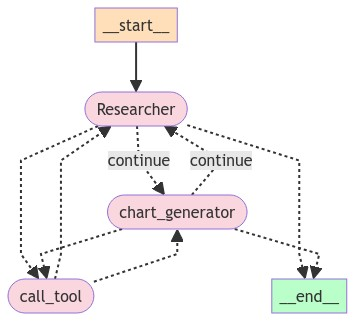

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QsXl5EKWSWsrWRlXVNBP0Coa', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 221, 'total_tokens': 246}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-0c93e46b-eb38-4bd6-848c-dc4a459ff84d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_QsXl5EKWSWsrWRlXVNBP0Coa'}], usage_metadata={'input_tokens': 221, 'output_tokens': 25, 'total_tokens': 246})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/GBR/united-kingdom/gdp-gross-domestic-product", "content": "U.K. gdp for 2021 was $3,141.5

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0v3EyDzVBrX0WqtXGHB0Wo7y', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# UK\'s GDP over the past 5 years (in billion USD)\\nyears = [\'2017\', \'2018\', \'2019\', \'2020\', \'2021\']\\ngdp_values = [2846.07, 2871.07, 2851.41, 2697.81, 3141.51]  # Estimated for 2017 and 2018\\n\\n# Create a line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'UK GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 181, 'prompt_tokens': 3029, 'total_tokens': 3210}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='chart_generator', id='run-2b16fa5a-df8e-4e1c-a254-5448f65abf5b-0', tool_call

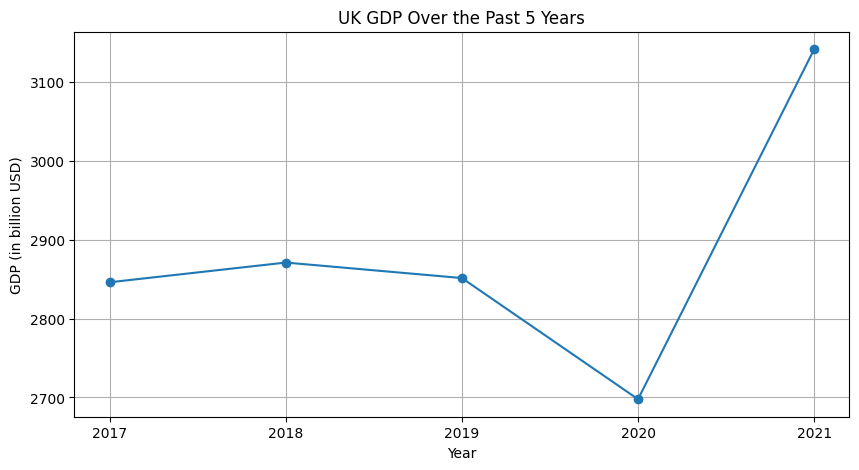

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# UK's GDP over the past 5 years (in billion USD)\nyears = ['2017', '2018', '2019', '2020', '2021']\ngdp_values = [2846.07, 2871.07, 2851.41, 2697.81, 3141.51]  # Estimated for 2017 and 2018\n\n# Create a line graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o')\nplt.title('UK GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_0v3EyDzVBrX0WqtXGHB0Wo7y')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER\n\nThe line graph has been generated using the provided UK GDP data for the past 5 years, although it is not visible in this text-based environment. If this were an environment with graphical capabilities, you would see a line graph depicting the U

In [27]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")